<a href="https://colab.research.google.com/github/shekh5/Git-and-Github-Workshop-/blob/main/Novel_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Import Libraries & Load Image


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(img, title="Image"):
    plt.figure(figsize=(6,6))
    plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")


Step 2: SIFT Keypoint Detection + Descriptor Extraction

In [20]:
def extract_sift(img_gray):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)
    return keypoints, descriptors


Step 3: AKAZE Keypoint Detection + Descriptor Extraction

In [21]:
def extract_akaze(img_gray):
    akaze = cv2.AKAZE_create()
    keypoints, descriptors = akaze.detectAndCompute(img_gray, None)
    return keypoints, descriptors


Step 4: Feature Matching (FLANN for SIFT, BF for AKAZE)

In [22]:
def match_features(desc1, desc2, method="sift"):
    if method == "sift":
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(desc1, desc2, k=2)

    elif method == "akaze":
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        matches = bf.knnMatch(desc1, desc2, k=2)

    # Lowe's ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    return good


Step 5: RANSAC to find forged (duplicate) regions

In [23]:
def ransac_filter(kp1, kp2, good_matches):
    if len(good_matches) < 4:
        return None, None

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    return H, mask


Step 6: Draw Matched Keypoints (for visualization)

In [24]:
def draw_matches(img, kp1, kp2, good, mask):
    matchesMask = mask.ravel().tolist()
    draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       matchesMask=matchesMask,
                       flags=2)
    result = cv2.drawMatches(img, kp1, img, kp2, good, None, **draw_params)
    return result


CMFD function

In [25]:
def cmfd_sift_akaze(path):
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # --- SIFT ---
    kp_s, desc_s = extract_sift(img_gray)
    good_s = match_features(desc_s, desc_s, "sift")
    H_s, mask_s = ransac_filter(kp_s, kp_s, good_s)

    # --- AKAZE ---
    kp_a, desc_a = extract_akaze(img_gray)
    good_a = match_features(desc_a, desc_a, "akaze")
    H_a, mask_a = ransac_filter(kp_a, kp_a, good_a)

    return {
        "img": img,
        "sift": (kp_s, good_s, mask_s),
        "akaze": (kp_a, good_a, mask_a)
    }


In [31]:
import cv2
import numpy as np
import time

def measure_sift(img_gray):
    sift = cv2.SIFT_create()

    t0 = time.time()
    kp, desc = sift.detectAndCompute(img_gray, None)
    t1 = time.time()

    # FLANN Matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(desc, desc, k=2)

    # Ratio test
    good = [m for m, n in matches if m.distance < 0.75*n.distance]

    return {
        "time": (t1 - t0),
        "keypoints": len(kp),
        "matches": len(good)
    }

def measure_akaze(img_gray):
    akaze = cv2.AKAZE_create()

    t0 = time.time()
    kp, desc = akaze.detectAndCompute(img_gray, None)
    t1 = time.time()

    # BF Matcher (HAMMING)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.knnMatch(desc, desc, k=2)

    # Ratio test
    good = [m for m, n in matches if m.distance < 0.75*n.distance]

    return {
        "time": (t1 - t0),
        "keypoints": len(kp),
        "matches": len(good)
    }


# ---------------- RUN ---------------- #

img = cv2.imread("/content/drive/MyDrive/dataset/CASIA/CASIA-CMFD/Tp/Tp_S_CNN_S_N_sec20015_sec20015_01605.tif")

# Check if the image was loaded successfully
if img is None:
    print("Error: Could not load image 'test_ai_edited_image.png'. Please ensure the file exists and the path is correct.")
else:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    result_sift = measure_sift(gray)
    result_akaze = measure_akaze(gray)

    print("===== SIFT === SST")
    print("Time Taken      :", result_sift["time"], "seconds")
    print("Keypoints Found :", result_sift["keypoints"])
    print("Good Matches    :", result_sift["matches"])

    print("\n===== AKAZE === SST")
    print("Time Taken      :", result_akaze["time"], "seconds")
    print("Keypoints Found :", result_akaze["keypoints"])
    print("Good Matches    :", result_akaze["matches"])


===== SIFT === SST
Time Taken      : 0.16132378578186035 seconds
Keypoints Found : 707
Good Matches    : 707

===== AKAZE === SST
Time Taken      : 0.06525683403015137 seconds
Keypoints Found : 311
Good Matches    : 311


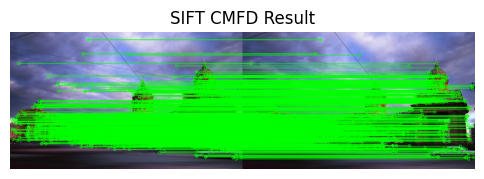

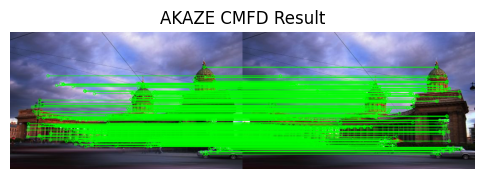

In [32]:
result = cmfd_sift_akaze("/content/drive/MyDrive/dataset/CASIA/CASIA-CMFD/Tp/Tp_S_CNN_S_N_sec20015_sec20015_01605.tif")

img = result["img"]

kp_s, good_s, mask_s = result["sift"]
kp_a, good_a, mask_a = result["akaze"]

sift_vis = draw_matches(img, kp_s, kp_s, good_s, mask_s)
akaze_vis = draw_matches(img, kp_a, kp_a, good_a, mask_a)

show(sift_vis, "SIFT CMFD Result")
show(akaze_vis, "AKAZE CMFD Result")
